# Data Retrieval

This may not work on windows so just use the extracted NIPS papers data from the __`nipstxt/`__ folder present in the same directory as this notebook which already has the data pre-downloaded and extracted

In [3]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

--2018-11-07 18:59:33--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 128.122.49.30
Connecting to cs.nyu.edu (cs.nyu.edu)|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  1.75MB/s    in 7.4s    

2018-11-07 18:59:41 (1.65 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



# Data Extraction

In [5]:
!tar -xzf nips12raw_str602.tgz

# Load and Pre-process Data

In [17]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips01', 'nips04', 'MATLAB_NOTES', 'nips10', 'nips02', 'idx', 'nips11', 'nips03', 'nips07', 'README_yann', 'nips05', 'nips12', 'nips06', 'RAW_DATA_NOTES', 'orig', 'nips00', 'nips08', 'nips09']


In [2]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [3]:
print(papers[0][:1000])

652 
Scaling Properties of Coarse-Coded Symbol Memories 
Ronald Rosenfeld 
David S. Touretzky 
Computer Science Department 
Carnegie Mellon University 
Pittsburgh, Pennsylvania 15213 
Abstract
Coarse-coded symbol memories have appeared in several neural network 
symbol processing models. In order to determine how these models would scale, one 
must first have some understanding of the mathematics of coarse-coded representa- 
tions. We define the general structure of coarse-coded symbol memories and derive 
mathematical relationships among their essential parameters: memort size, slmbol-set 
size and capacitor. The computed capacity of one of the schemes agrees well with actual 
measurements of the coarse-coded working memory of DCPS, Touretzky and Hinton's 
distributed connectionist production system. 
1 Introduction 
A dstributed representation is a memory scheme in which each entity (concept, symbol) 
is represented by a pattern of activity over many units [3]. If each unit partic

## Basic Text Wrangling

In [56]:
%%time
import nltk

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
CPU times: user 38.6 s, sys: 92 ms, total: 38.7 s
Wall time: 38.7 s


In [5]:
print(norm_papers[0][:50])

['scaling', 'property', 'coarse', 'coded', 'symbol', 'memory', 'ronald', 'rosenfeld', 'david', 'touretzky', 'computer', 'science', 'department', 'carnegie', 'mellon', 'university', 'pittsburgh', 'pennsylvania', 'abstract', 'coarse', 'coded', 'symbol', 'memory', 'appeared', 'several', 'neural', 'network', 'symbol', 'processing', 'model', 'order', 'determine', 'model', 'would', 'scale', 'one', 'must', 'first', 'understanding', 'mathematics', 'coarse', 'coded', 'representa', 'tions', 'define', 'general', 'structure', 'coarse', 'coded', 'symbol']


# Text Representation with Feature Engineering

In [6]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['scaling', 'property', 'coarse_coded', 'symbol', 'memory', 'ronald', 'rosenfeld', 'david_touretzky', 'computer_science', 'department', 'carnegie_mellon', 'university_pittsburgh', 'pennsylvania', 'abstract', 'coarse_coded', 'symbol', 'memory', 'appeared', 'several', 'neural_network', 'symbol', 'processing', 'model', 'order', 'determine', 'model', 'would', 'scale', 'one', 'must', 'first', 'understanding', 'mathematics', 'coarse_coded', 'representa_tions', 'define', 'general', 'structure', 'coarse_coded', 'symbol', 'memory', 'derive', 'mathematical', 'relationship', 'among', 'essential', 'parameter', 'memor', 'size', 'lmbol']


In [7]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '8a'), (1, 'abandon'), (2, 'able'), (3, 'abo'), (4, 'abstract'), (5, 'accommodate'), (6, 'accuracy'), (7, 'achieved'), (8, 'acknowledgment_thank'), (9, 'across'), (10, 'active'), (11, 'activity'), (12, 'actual'), (13, 'adjusted'), (14, 'adjusting')]
Total Vocabulary Size: 78892


In [8]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


In [9]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(4, 1), (14, 2), (20, 1), (28, 1), (33, 1), (43, 1), (50, 1), (60, 2), (61, 1), (62, 2), (63, 1), (72, 1), (84, 1), (88, 3), (102, 2), (109, 2), (112, 5), (122, 6), (125, 4), (127, 3), (129, 2), (130, 4), (133, 5), (141, 3), (157, 1), (158, 1), (173, 1), (174, 1), (177, 1), (183, 1), (189, 1), (192, 1), (207, 1), (213, 1), (214, 3), (227, 2), (234, 1), (237, 1), (239, 1), (244, 4), (252, 4), (256, 4), (272, 1), (277, 1), (280, 2), (286, 39), (296, 6), (306, 1), (307, 2), (316, 1)]


In [10]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('achieved', 1), ('allow', 2), ('american_institute', 1), ('another', 1), ('appeared', 1), ('argument', 1), ('assume', 1), ('become', 2), ('becomes', 1), ('behavior', 2), ('behavioral', 1), ('bounded', 1), ('cause', 1), ('certain', 3), ('column', 2), ('complete', 2), ('computational', 5), ('connection', 6), ('consider', 4), ('considered', 3), ('consists', 2), ('constant', 4), ('constraint', 5), ('corresponding', 3), ('denote', 1), ('density', 1), ('determines', 1), ('developed', 1), ('dimension', 1), ('distributed_processing', 1), ('ed_parallel', 1), ('effect', 1), ('enforced', 1), ('equal', 1), ('equation', 3), ('every', 2), ('except', 1), ('expected', 1), ('experiment', 1), ('expression', 4), ('finally', 4), ('fixed', 4), ('furthermore', 1), ('give', 1), ('good', 2), ('group', 39), ('hence', 6), ('implementation', 1), ('implemented', 2), ('independent', 1)]


In [11]:
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


# Topic Models with Latent Semantic Indexing (LSI)

In [12]:
%%time

TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS,
                                 onepass=True, chunksize=1740, power_iters=1000)

CPU times: user 54min 30s, sys: 3min 21s, total: 57min 51s
Wall time: 3min 51s


In [13]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.215*"unit" + 0.212*"state" + 0.187*"training" + 0.177*"neuron" + 0.162*"pattern" + 0.145*"image" + 0.140*"vector" + 0.125*"feature" + 0.122*"cell" + 0.110*"layer" + 0.101*"task" + 0.097*"class" + 0.091*"probability" + 0.089*"signal" + 0.087*"step" + 0.086*"response" + 0.085*"representation" + 0.083*"noise" + 0.082*"rule" + 0.081*"distribution"

Topic #2:
-0.487*"neuron" + -0.396*"cell" + 0.257*"state" + -0.191*"response" + 0.187*"training" + -0.170*"stimulus" + -0.117*"activity" + 0.109*"class" + -0.099*"spike" + -0.097*"pattern" + -0.096*"circuit" + -0.096*"synaptic" + 0.095*"vector" + -0.090*"signal" + -0.090*"firing" + -0.088*"visual" + 0.084*"classifier" + 0.083*"action" + 0.078*"word" + -0.078*"cortical"

Topic #3:
-0.627*"state" + 0.395*"image" + -0.219*"neuron" + 0.209*"feature" + -0.188*"action" + 0.137*"unit" + 0.131*"object" + -0.130*"control" + 0.129*"training" + -0.109*"policy" + 0.103*"classifier" + 0.090*"class" + -0.081*"step" + -0.081*"dynamic" + 0.080*"clas

In [14]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()
    

Topic #1:
Direction 1: [('unit', 0.215), ('state', 0.212), ('training', 0.187), ('neuron', 0.177), ('pattern', 0.162), ('image', 0.145), ('vector', 0.14), ('feature', 0.125), ('cell', 0.122), ('layer', 0.11), ('task', 0.101), ('class', 0.097), ('probability', 0.091), ('signal', 0.089), ('step', 0.087), ('response', 0.086), ('representation', 0.085), ('noise', 0.083), ('rule', 0.082), ('distribution', 0.081)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('state', 0.257), ('training', 0.187), ('class', 0.109), ('vector', 0.095), ('classifier', 0.084), ('action', 0.083), ('word', 0.078)]
--------------------------------------------------
Direction 2: [('neuron', -0.487), ('cell', -0.396), ('response', -0.191), ('stimulus', -0.17), ('activity', -0.117), ('spike', -0.099), ('pattern', -0.097), ('circuit', -0.096), ('synaptic', -0.096), ('signal', -0.09), ('firing', -0.09), ('visual', -0.088), (

In [15]:
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [18]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.038,0.002,0.009,-0.077,-0.010,-0.018,0.030,-0.072,0.000,0.005
1,0.022,0.000,-0.022,0.008,0.011,-0.016,0.013,-0.017,0.001,0.007
2,0.021,-0.028,-0.004,0.003,-0.003,0.000,-0.008,0.009,0.008,-0.014
3,0.024,-0.048,0.011,0.003,-0.023,0.044,-0.002,-0.011,-0.003,0.016
4,0.032,-0.020,-0.013,0.013,-0.003,0.058,-0.006,-0.050,-0.061,0.036
5,0.085,-0.183,-0.003,-0.022,-0.019,0.307,-0.087,-0.137,-0.040,0.020
6,0.020,-0.034,-0.019,0.003,0.017,-0.042,-0.012,-0.014,-0.002,-0.012
7,0.012,0.006,0.007,-0.018,0.008,-0.001,-0.004,0.005,-0.003,-0.013
8,0.033,-0.071,-0.017,0.003,0.018,0.009,-0.020,-0.019,0.011,-0.011
9,0.027,0.007,0.027,0.041,-0.016,-0.008,0.036,0.006,-0.005,0.006


In [19]:
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T6', 'T1', 'T2']
Paper Summary:
9 
Stochastic Learning Networks and their Electronic Implementation 
Joshua Alspector*, Robert B. Allen, Victor Hut, and Srinagesh Satyanarayana 
Bell Communications Research, Morristown, NJ 07960 
ABSTRACT
We describe a family of learning algorithms that operate on a recurrent, symmetrically 
connected, neuromorphic network that, like the Boltzmann machine, settles in the 
presence of noise. These networks learn by modifying synaptic connection strengths on 
the basis of correlations seen loca

Document #250:
Dominant Topics (top 3): ['T3', 'T5', 'T8']
Paper Summary:
266 Zemel, Mozer and Hinton 
TRAFFIC: Recognizing Objects Using 
Hierarchical Reference Frame Transformations 
Richard S. Zemel 
Computer Science Dept. 
University of Toronto 
Toronto, ONT M5S 1A4 
Michael C. Mozer 
Computer Science Dept. 
University of Colorado 
Boulder, CO 80309-0430 
Geoffrey E. Hinton 
Computer Science Dept. 
University of Toron

# Implementing LSI Topic Models from Scratch

In [20]:
td_matrix = gensim.matutils.corpus2dense(corpus=bow_corpus, num_terms=len(dictionary))
print(td_matrix.shape)
td_matrix

(7756, 1740)


array([[1., 0., 1., ..., 0., 2., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
vocabulary = np.array(list(dictionary.values()))
print('Total vocabulary size:', len(vocabulary))
vocabulary

Total vocabulary size: 7756


array(['able', 'abstract', 'accommodate', ..., 'support_vector',
       'mozer_jordan', 'kearns_solla'], dtype='<U28')

In [22]:
dictionary[0]

'able'

In [23]:
from scipy.sparse.linalg import svds

u, s, vt = svds(td_matrix, k=TOTAL_TOPICS, maxiter=10000)
term_topic = u
singular_values = s
topic_document = vt
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [24]:
tt_weights = term_topic.transpose() * singular_values[:, None]
tt_weights.shape

(10, 7756)

In [25]:
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(tt_weights), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([tt_weights[row, columns] 
                             for row, columns in list(zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weights[n]
    term_weights = sorted([(t, w) for t, w in zip(terms, weights)], 
                          key=lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('training', 92.618), ('task', 80.732), ('pattern', 70.619), ('classifier', 56.989), ('control', 50.677), ('rule', 45.926), ('action', 41.202), ('neuron', 38.193)]
--------------------------------------------------
Direction 2: [('word', -188.488), ('vector', -85.973), ('node', -54.376), ('recognition', -53.232), ('sequence', -50.351), ('circuit', -45.394), ('cell', -44.811), ('hmm', -34.086), ('character', -34.022), ('chip', -32.16), ('matrix', -32.093), ('structure', -30.993)]
--------------------------------------------------

Topic #2:
Direction 1: [('word', 78.347), ('neuron', 69.793), ('stimulus', 63.234), ('feature', 53.819), ('distribution', 53.119), ('response', 30.954), ('state', 29.343), ('probability', 29.099), ('estimate', 28.908)]
--------------------------------------------------
Direction 2: [('node', -173.277), ('circuit', -93.0), ('chip', -73.593), ('classifier', -58.717), ('current', -55.844), ('voltage', -53.489), ('control', -51.708), ('rule

In [26]:
import pandas as pd

document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,-0.005,0.000,0.072,0.030,0.018,0.010,-0.077,0.009,-0.002,-0.038
1,-0.007,0.001,0.017,0.013,0.016,-0.011,0.008,-0.022,-0.000,-0.022
2,0.014,0.008,-0.009,-0.008,-0.000,0.003,0.003,-0.004,0.028,-0.021
3,-0.016,-0.003,0.011,-0.002,-0.044,0.023,0.003,0.011,0.048,-0.024
4,-0.036,-0.061,0.050,-0.006,-0.058,0.003,0.013,-0.013,0.020,-0.032
5,-0.020,-0.040,0.137,-0.087,-0.307,0.019,-0.022,-0.003,0.183,-0.085
6,0.012,-0.002,0.014,-0.012,0.042,-0.017,0.003,-0.019,0.034,-0.020
7,0.013,-0.003,-0.005,-0.004,0.001,-0.008,-0.018,0.007,-0.006,-0.012
8,0.011,0.011,0.019,-0.020,-0.009,-0.018,0.003,-0.017,0.071,-0.033
9,-0.006,-0.005,-0.006,0.036,0.008,0.016,0.041,0.027,-0.007,-0.027


In [27]:
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T5', 'T10', 'T9']
Paper Summary:
9 
Stochastic Learning Networks and their Electronic Implementation 
Joshua Alspector*, Robert B. Allen, Victor Hut, and Srinagesh Satyanarayana 
Bell Communications Research, Morristown, NJ 07960 
ABSTRACT
We describe a family of learning algorithms that operate on a recurrent, symmetrically 
connected, neuromorphic network that, like the Boltzmann machine, settles in the 
presence of noise. These networks learn by modifying synaptic connection strengths on 
the basis of correlations seen loca

Document #250:
Dominant Topics (top 3): ['T6', 'T8', 'T3']
Paper Summary:
266 Zemel, Mozer and Hinton 
TRAFFIC: Recognizing Objects Using 
Hierarchical Reference Frame Transformations 
Richard S. Zemel 
Computer Science Dept. 
University of Toronto 
Toronto, ONT M5S 1A4 
Michael C. Mozer 
Computer Science Dept. 
University of Colorado 
Boulder, CO 80309-0430 
Geoffrey E. Hinton 
Computer Science Dept. 
University of Toro

# Topic Models with Latent Dirichlet Allocation (LDA)

In [28]:
%%time
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 5min 32s, sys: 10.7 s, total: 5min 43s
Wall time: 2min 31s


In [29]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.016*"training" + 0.012*"classifier" + 0.007*"pattern" + 0.007*"classification" + 0.006*"class" + 0.006*"task" + 0.006*"vector" + 0.005*"training_set" + 0.005*"feature" + 0.004*"control" + 0.004*"size" + 0.003*"trained" + 0.003*"teacher" + 0.003*"rate" + 0.003*"student" + 0.003*"average" + 0.003*"robot" + 0.003*"random" + 0.003*"rule" + 0.003*"search"

Topic #2:
0.008*"vector" + 0.006*"equation" + 0.006*"matrix" + 0.006*"neuron" + 0.005*"state" + 0.005*"dynamic" + 0.005*"solution" + 0.005*"unit" + 0.004*"node" + 0.004*"pattern" + 0.004*"linear" + 0.004*"let" + 0.003*"layer" + 0.003*"convergence" + 0.003*"rule" + 0.003*"size" + 0.003*"theorem" + 0.003*"threshold" + 0.003*"memory" + 0.003*"theory"

Topic #3:
0.017*"training" + 0.011*"word" + 0.008*"recognition" + 0.007*"trained" + 0.006*"net" + 0.006*"unit" + 0.006*"feature" + 0.006*"speech" + 0.006*"task" + 0.005*"architecture" + 0.005*"class" + 0.005*"character" + 0.004*"layer" + 0.004*"classification" + 0.004*"context" + 0.

In [30]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0433305600965899


In [31]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('training', 0.017), ('word', 0.011), ('recognition', 0.008), ('trained', 0.007), ('net', 0.006), ('unit', 0.006), ('feature', 0.006), ('speech', 0.006), ('task', 0.006), ('architecture', 0.005), ('class', 0.005), ('character', 0.005), ('layer', 0.004), ('classification', 0.004), ('context', 0.004), ('test', 0.004), ('sequence', 0.004), ('hidden_unit', 0.004), ('experiment', 0.004), ('vector', 0.004)]

Topic #2:
[('unit', 0.03), ('pattern', 0.009), ('representation', 0.007), ('activation', 0.007), ('hidden_unit', 0.006), ('node', 0.006), ('structure', 0.006), ('layer', 0.006), ('activity', 0.005), ('connection', 0.004), ('task', 0.004), ('component', 0.004), ('map', 0.004), ('rule', 0.004), ('architecture', 0.004), ('signal', 0.004), ('level', 0.004), ('response', 0.003), ('connectionist', 0.003), ('training', 0.003)]

Topic #3:
[('neuron', 0.021), ('cell', 0.019), ('response', 0.009), ('activity', 0.007), ('stimulus', 0.007), ('pattern', 0.007), ('sp

In [32]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['training', 'word', 'recognition', 'trained', 'net', 'unit', 'feature', 'speech', 'task', 'architecture', 'class', 'character', 'layer', 'classification', 'context', 'test', 'sequence', 'hidden_unit', 'experiment', 'vector']

Topic #2:
['unit', 'pattern', 'representation', 'activation', 'hidden_unit', 'node', 'structure', 'layer', 'activity', 'connection', 'task', 'component', 'map', 'rule', 'architecture', 'signal', 'level', 'response', 'connectionist', 'training']

Topic #3:
['neuron', 'cell', 'response', 'activity', 'stimulus', 'pattern', 'spike', 'synaptic', 'cortical', 'neural', 'signal', 'firing', 'connection', 'effect', 'layer', 'et_al', 'cortex', 'visual', 'simulation', 'synapsis']

Topic #4:
['image', 'object', 'feature', 'pixel', 'visual', 'representation', 'face', 'vector', 'view', 'recognition', 'transformation', 'local', 'map', 'structure', 'region', 'filter', 'position', 'distance', 'part', 'location']

Topic #5:
['vector', 'equation'

In [33]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.47028476052247825
Avg. Coherence Score (UMass): -1.0433305600965896
Model Perplexity: -7.792233498252204


# LDA Models with MALLET

In [267]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2018-11-08 20:06:13--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  1.35MB/s    in 12s     

2018-11-08 20:06:25 (1.28 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [271]:
!unzip -q mallet-2.0.8.zip

In [34]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=16)

In [35]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_mallet.show_topic(n, topn=20)] 
                   for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['neuron', 'cell', 'response', 'stimulus', 'activity', 'pattern', 'signal', 'spike', 'effect', 'synaptic', 'frequency', 'neural', 'unit', 'connection', 'layer', 'cortical', 'firing', 'et_al', 'brain', 'temporal']

Topic #2:
['prediction', 'control', 'trajectory', 'target', 'task', 'expert', 'training', 'nonlinear', 'dynamic', 'linear', 'local', 'change', 'adaptive', 'mapping', 'hand', 'movement', 'controller', 'position', 'motor', 'architecture']

Topic #3:
['vector', 'equation', 'linear', 'bound', 'solution', 'theory', 'matrix', 'convergence', 'theorem', 'defined', 'size', 'constant', 'optimal', 'class', 'eq', 'property', 'approximation', 'condition', 'rate', 'probability']

Topic #4:
['state', 'action', 'step', 'policy', 'environment', 'recurrent', 'transition', 'optimal', 'task', 'reinforcement_learning', 'control', 'path', 'goal', 'stochastic', 'sequence', 'current', 'cost', 'iteration', 'machine', 'update']

Topic #5:
['image', 'object', 'feature', 'motion', 'visual', 'm

In [38]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5008326905758488
Avg. Coherence Score (UMass): -1.0635635291342118
Model Perplexity: -8.53533


# LDA Tuning - Finding Optimal Number of Topics

In [39]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [40]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=16)

100%|██████████| 29/29 [37:48<00:00, 92.53s/it]


In [42]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
24,26,0.5461
23,25,0.5427
17,19,0.5419
16,18,0.5412
22,24,0.5405
18,20,0.5401
21,23,0.5375
20,22,0.5369
19,21,0.5369
27,29,0.5363


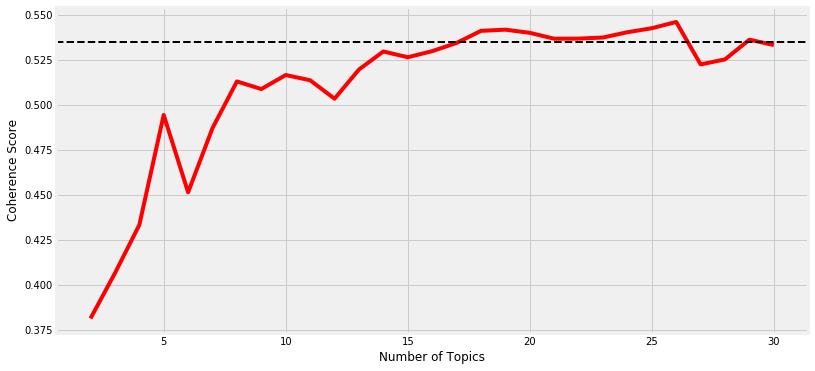

In [43]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [44]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

In [45]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['class', 'classification', 'classifier', 'training', 'pattern', 'feature', 'kernel', 'machine', 'training_set', 'test', 'sample', 'vector', 'database', 'error_rate', 'margin', 'experiment', 'support_vector', 'nearest_neighbor', 'decision', 'size']

Topic #2:
['neuron', 'memory', 'pattern', 'dynamic', 'connection', 'phase', 'attractor', 'capacity', 'state', 'hopfield', 'neural', 'fixed_point', 'oscillator', 'delay', 'stable', 'fig', 'oscillation', 'associative_memory', 'behavior', 'stored']

Topic #3:
['word', 'recognition', 'training', 'speech', 'character', 'context', 'hmm', 'letter', 'mlp', 'speaker', 'feature', 'frame', 'trained', 'speech_recognition', 'phoneme', 'experiment', 'hybrid', 'segmentation', 'vowel', 'level']

Topic #4:
['noise', 'rate', 'equation', 'curve', 'average', 'correlation', 'rule', 'distribution', 'theory', 'limit', 'solution', 'optimal', 'eq', 'teacher', 'effect', 'size', 'temperature', 'student', 'line', 'random']

Topic #5:
['bound', 'theorem', 'cl

In [46]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,class,neuron,word,noise,bound,vector,search,distribution,visual,neuron,state,node,image,control,unit,circuit,rule,vector,signal,prediction
Term2,classification,memory,recognition,rate,theorem,matrix,task,probability,motion,cell,sequence,tree,object,action,layer,chip,representation,map,filter,training
Term3,classifier,pattern,training,equation,class,linear,experiment,prior,cell,spike,step,structure,feature,state,training,current,module,distance,frequency,estimate
Term4,training,dynamic,speech,curve,probability,equation,table,gaussian,response,synaptic,recurrent,graph,pixel,policy,hidden_unit,analog,structure,cluster,source,regression
Term5,pattern,connection,character,average,size,solution,instance,variable,stimulus,activity,transition,code,face,environment,net,voltage,human,local,channel,test
Term6,feature,phase,context,correlation,threshold,gradient,test,mixture,direction,response,stochastic,level,view,controller,architecture,implementation,movement,dimension,noise,noise
Term7,kernel,attractor,hmm,rule,proof,constraint,domain,density,receptive_field,stimulus,iteration,bit,recognition,reinforcement_learning,pattern,processor,motor,clustering,component,selection
Term8,machine,capacity,letter,distribution,polynomial,convergence,target,bayesian,map,firing,update,path,representation,task,activation,bit,target,mapping,response,variance
Term9,training_set,state,mlp,theory,theory,optimization,query,estimate,spatial,synapsis,dynamic,local,shape,optimal,trained,design,language,dimensional,temporal,training_set
Term10,test,hopfield,speaker,limit,complexity,nonlinear,feature,approximation,orientation,et_al,probability,size,scale,robot,task,device,subject,region,sound,sample


In [47]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

,Terms per Topic
Topic1,"class, classification, classifier, training, pattern, feature, kernel, machine, training_set, test, sample, vector, database, error_rate, margin, experiment, support_vector, nearest_neighbor, decision, size"
Topic2,"neuron, memory, pattern, dynamic, connection, phase, attractor, capacity, state, hopfield, neural, fixed_point, oscillator, delay, stable, fig, oscillation, associative_memory, behavior, stored"
Topic3,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level"
Topic4,"noise, rate, equation, curve, average, correlation, rule, distribution, theory, limit, solution, optimal, eq, teacher, effect, size, temperature, student, line, random"
Topic5,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded"
Topic6,"vector, matrix, linear, equation, solution, gradient, constraint, convergence, optimization, nonlinear, optimal, eq, minimum, operator, gradient_descent, condition, constant, derivative, quadratic, energy"
Topic7,"search, task, experiment, table, instance, test, domain, target, query, feature, user, random, technique, run, accuracy, block, application, evaluation, strategy, important"
Topic8,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, entropy"
Topic9,"visual, motion, cell, response, stimulus, direction, receptive_field, map, spatial, orientation, unit, eye, field, activity, location, velocity, center, contrast, cortical, pattern"
Topic10,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate"


# Interpreting Topic Model Results

In [48]:
tm_results = best_lda_model[bow_corpus]

In [49]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(16, 0.2115988756613756),
 (5, 0.29989652050187554),
 (9, 0.3307915758896151),
 (8, 0.5447463768115942),
 (9, 0.18093823158652983)]

In [50]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

## Dominant Topics Distribution across Corpus

In [51]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
                                                'Dominant Topic': {
                                                    'Doc Count': np.size,
                                                    '% Total Docs': np.size }
                                              })
topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df

/home/paperspace/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,Dominant Topic,Doc Count,% Total Docs,Topic Desc
0,1,75,4.31,"class, classification, classifier, training, pattern, feature, kernel, machine, training_set, test, sample, vector, database, error_rate, margin, experiment, support_vector, nearest_neighbor, deci..."
1,2,69,3.97,"neuron, memory, pattern, dynamic, connection, phase, attractor, capacity, state, hopfield, neural, fixed_point, oscillator, delay, stable, fig, oscillation, associative_memory, behavior, stored"
2,3,78,4.48,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level"
3,4,68,3.91,"noise, rate, equation, curve, average, correlation, rule, distribution, theory, limit, solution, optimal, eq, teacher, effect, size, temperature, student, line, random"
4,5,105,6.03,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded"
5,6,80,4.60,"vector, matrix, linear, equation, solution, gradient, constraint, convergence, optimization, nonlinear, optimal, eq, minimum, operator, gradient_descent, condition, constant, derivative, quadratic..."
6,7,66,3.79,"search, task, experiment, table, instance, test, domain, target, query, feature, user, random, technique, run, accuracy, block, application, evaluation, strategy, important"
7,8,148,8.51,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent..."
8,9,117,6.72,"visual, motion, cell, response, stimulus, direction, receptive_field, map, spatial, orientation, unit, eye, field, activity, location, velocity, center, contrast, cortical, pattern"
9,10,141,8.10,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate"


## Dominant Topics in Specific Research Papers

In [52]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([681, 9, 392, 1622, 17, 
                        906, 996, 503, 13, 733])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
9,9,13,29.10,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","622 \nLEARNING A COLOR ALGORITHM FROM EXAMPLES \nAnya C. Hurlbert and Tomaso A. Poggio \nArtificial Intelligence Laboratory and Department of Brain and Cognitive Sciences, \nMassachusetts Institut..."
13,13,16,27.12,"circuit, chip, current, analog, voltage, implementation, processor, bit, design, device, computation, parallel, digital, operation, array, neural, synapse, element, hardware, transistor","9 \nStochastic Learning Networks and their Electronic Implementation \nJoshua Alspector*, Robert B. Allen, Victor Hut, and Srinagesh Satyanarayana \nBell Communications Research, Morristown, NJ 0..."
17,17,5,23.00,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","338 \nThe Connectivity Analysis of Simple Association \nHow Many Connections Do You Need? \nDan Hammerstrom * \nOregon Graduate Center, Beaverton, OR 97006 \nABSTRACT \nThe efficient realization, ..."
392,392,14,67.03,"control, action, state, policy, environment, controller, reinforcement_learning, task, optimal, robot, goal, step, reward, td, agent, adaptive, cost, reinforcement, trial, exploration","Integrated Modeling and Control \nBased on Reinforcement Learning \nand Dynamic Programming \nRichard S. Sutton \nGTE Laboratories Incorporated \nWaltham, MA 02254 \nAbstract \nThis is a summary o..."
503,503,3,60.76,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Multi-State Time Delay Neural Networks \nfor Continuous Speech Recognition \nPatrick Haffner \nCNET Lannion A TSS/RCP \n22301 LANNION, FRANCE \nhaffnerlannion.cnet. fr \nAlex Waibel \nCarnegie Me..."
681,681,3,67.58,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Connected Letter Recognition with a \nMulti-State Time Delay Neural Network \nHermann Hild and Alex Waibel \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213-3891, US..."
733,733,16,45.55,"circuit, chip, current, analog, voltage, implementation, processor, bit, design, device, computation, parallel, digital, operation, array, neural, synapse, element, hardware, transistor","High Performance Neural Net Simulation \non a Multiprocessor System with \n""Intelligent"" Communication \nUrs A. Miiller, Michael Kocheisen, and Anton Gunzinger \nElectronics Laboratory, Swiss Fede..."
906,906,10,56.44,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate","A model of the hippocampus combining self- \norganization and associative memory function. \nMichael E. Hasselmo, Eric Schnell \nJoshua Berke and Edi Barkai \nDept. of Psychology, Harvard Universi..."
996,996,19,65.69,"signal, filter, frequency, source, channel, noise, component, response, temporal, sound, auditory, detection, phase, ica, adaptation, amplitude, subject, eeg, change, correlation","Using Feedforward Neural Networks to \nMonitor Alertness from Changes in EEG \nCorrelation and Coherence \nScott Makeig \nNaval Health Research Center, P.O. Box 85122 \nSan Diego, CA 92186-5122 \n..."
1622,1622,8,56.70,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent...","The Infinite Gaussian Mixture Model \nCarl Edward Rasmussen \nDepartment of Mathematical Modellin

## Relevant Research Papers per Topic based on Dominance

In [53]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,1138,1,61.01,"class, classification, classifier, training, pattern, feature, kernel, machine, training_set, test, sample, vector, database, error_rate, margin, experiment, support_vector, nearest_neighbor, deci...","Improving the Accuracy and Speed of \nSupport Vector Machines \nChris J.C. Burges \nBell Laboratories \nLucent Technologies, Room 3G429 \n101 Crawford's Corner Road \nHolmdel, NJ 07733-3030 \nburg..."
2,131,2,56.71,"neuron, memory, pattern, dynamic, connection, phase, attractor, capacity, state, hopfield, neural, fixed_point, oscillator, delay, stable, fig, oscillation, associative_memory, behavior, stored","568 \nDYNAMICS OF ANALOG NEURAL \nNETWORKS WITH TIME DELAY \nC.M. Marcus and R.M. Westervelt \nDivision of Applied Sciences and Department of Physics \nHarvard University, Cambridge Massachusetts ..."
3,681,3,67.58,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Connected Letter Recognition with a \nMulti-State Time Delay Neural Network \nHermann Hild and Alex Waibel \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213-3891, US..."
4,1570,4,73.69,"noise, rate, equation, curve, average, correlation, rule, distribution, theory, limit, solution, optimal, eq, teacher, effect, size, temperature, student, line, random","Dynamics of Supervised Learning with \nRestricted Training Sets \nA.C.C. Coolen \nDept of Mathematics \nKing's College London \nStrand, London WC2R 2LS, UK \ntcoolen @mth.kcl.ac.uk \nD. Saad \nNeu..."
5,431,5,81.06,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","Polynomial Uniform Convergence of \nRelative Frequencies to Probabilities \nAlberto Bertoni, Paola Campadelll;' Anna Morpurgo, Sandra Panlzza \nDipartimento di Scienze dell'Informazione \nUniversi..."
6,82,6,57.12,"vector, matrix, linear, equation, solution, gradient, constraint, convergence, optimization, nonlinear, optimal, eq, minimum, operator, gradient_descent, condition, constant, derivative, quadratic...","612 \nConstrained Differential Optimization \nJohn C. Platt \nAlan H. Ban' \nCalifornia Institute of Technology, Pasadena, CA 91125 \nAbstract \nMany optimization models of neural networks need co..."
7,741,7,62.82,"search, task, experiment, table, instance, test, domain, target, query, feature, user, random, technique, run, accuracy, block, application, evaluation, strategy, important","When Will a Genetic Algorithm \nOutperform Hill Climbing? \nMelanie Mitchell \nSanta Fe Institute \n1660 Old Pecos Trail, Suite A \nSanta Fe, NM 87501 \nJohn H. Holland \nDept. of Psychology \nUni..."
8,1375,8,61.11,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent...",Approximating Posterior Distributions \nin Belief Networks using Mixtures \nChristopher M. Bishop \nNeil Lawrence \nNeural Computing Research Group \nDept. Computer Science & Applied Mathematics \...
9,808,9,66.59,"visual, motion, cell, response, stimulus, direction, receptive_field, map, spatial, orientation, unit, eye, field, activity, location, velocity, center, contrast, cortical, pattern","Development of Orientation and Ocular \nDominance Columns in Infant Macaques \nKlaus Obermayer \nHoward Hughes Medical Institute \nSMk-Institute \nLa Jolla, CA 92037 \nLynne Kiorpes \nCenter for N..."


# Predicting Topics for New Research Papers

In [66]:
import glob
# papers manually downloaded from NIPS 16
# https://papers.nips.cc/book/advances-in-neural-information-processing-systems-29-2016

new_paper_files = glob.glob('nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
              
print('Total New Papers:', len(new_papers))

Total New Papers: 4


In [67]:
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, 
                                              bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)

In [68]:
print(norm_new_papers[0][:30])

['cooperative', 'graphical_model', 'josip', 'djolonga', 'dept_computer', 'science', 'eth', 'zurich', 'josipd', 'inf', 'ethz', 'ch', 'stefanie', 'jegelka', 'csail', 'mit', 'stefje', 'mit_edu', 'sebastian', 'tschiatschek', 'dept_computer', 'science', 'eth', 'zurich', 'stschia', 'inf', 'ethz', 'ch', 'andreas', 'krause']


In [69]:
print(norm_bow_features[0][:30])

[(0, 1), (1, 1), (6, 1), (17, 1), (18, 1), (19, 1), (25, 1), (31, 2), (36, 2), (38, 1), (39, 17), (41, 3), (43, 1), (45, 1), (49, 2), (50, 4), (51, 1), (52, 2), (54, 1), (60, 1), (65, 1), (66, 3), (68, 7), (71, 8), (76, 4), (77, 2), (87, 1), (88, 3), (105, 1), (106, 1)]


In [70]:
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) 
                        for topic, wt in sorted(topic_predictions[i], 
                                                key=lambda row: -row[1])[:topn]] 
                            for i in range(len(topic_predictions))]
    return best_topics

In [71]:
topic_preds = get_topic_predictions(topic_model=best_lda_model, 
                                    corpus=norm_bow_features, topn=2)
topic_preds

[[(7, 0.241), (4, 0.199)],
 [(13, 0.293), (4, 0.248)],
 [(12, 0.238), (9, 0.113)],
 [(2, 0.263), (12, 0.145)]]

In [72]:
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item] for item in topic_preds]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in 
                                        [[round(wt*100, 2) 
                                              for topic_num, wt in item] 
                                                 for item in topic_preds] 
                                    for topic_wt in topic_list]

results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]

In [73]:
pd.set_option('display.max_colwidth', 300)
results_df

,Dominant Topics,Contribution %,Topic Desc,Paper Desc
Papers,,,,
1,8,24.1,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, entropy","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer Science, ETH"
1,5,19.9,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer Science, ETH"
2,14,29.3,"control, action, state, policy, environment, controller, reinforcement_learning, task, optimal, robot, goal, step, reward, td, agent, adaptive, cost, reinforcement, trial, exploration","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York, NY 10011\na"
2,5,24.8,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York, NY 10011\na"
3,13,23.8,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\nUniversit"
3,10,11.3,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\nUniversit"
4,3,26.3,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute of Tech"
4,13,14.5,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute of Tech"
